# Advanced Atom Selection with SMARTS and Mapped SMILES

This notebook demonstrates the advanced atom selection capabilities in rdkit2ase, including support for mapped SMILES patterns and sophisticated hydrogen handling.

In [1]:
import rdkit2ase
from rdkit import Chem
from rdkit.Chem import Draw

## Basic Atom Selection with SMARTS

The `select_atoms_flat_unique` function provides advanced atom selection capabilities beyond the basic `match_substructure` function. Let's start with a simple example using ethanol.

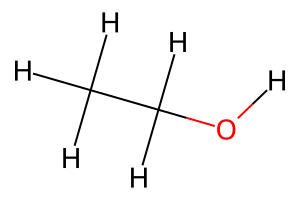

In [2]:
# Create an ethanol molecule with explicit hydrogens
ethanol_smiles = "CCO"
ethanol_mol = Chem.MolFromSmiles(ethanol_smiles)
ethanol_mol = Chem.AddHs(ethanol_mol)

# Display the molecule
Draw.MolToImage(ethanol_mol, size=(300, 200))

In [3]:
# Select all carbon atoms using SMARTS
carbon_indices = rdkit2ase.select_atoms_flat_unique(ethanol_mol, "[#6]")
print(f"Carbon atom indices: {carbon_indices}")

# Select the oxygen atom
oxygen_indices = rdkit2ase.select_atoms_flat_unique(ethanol_mol, "[#8]")
print(f"Oxygen atom indices: {oxygen_indices}")

Carbon atom indices: [0, 1]
Oxygen atom indices: [2]


## Hydrogen Handling Options

One of the key features is sophisticated hydrogen handling with three different modes: `exclude` (default), `include`, and `isolated`.

In [4]:
# Select the C-O bond pattern with different hydrogen handling
pattern = "CO"  # Carbon-Oxygen bond

# Default: exclude hydrogens
exclude_h = rdkit2ase.select_atoms_flat_unique(ethanol_mol, pattern, hydrogens="exclude")
print(f"Exclude hydrogens: {exclude_h}")

# Include hydrogens attached to matched heavy atoms
include_h = rdkit2ase.select_atoms_flat_unique(ethanol_mol, pattern, hydrogens="include")
print(f"Include hydrogens: {include_h}")

# Return only the hydrogens attached to matched heavy atoms
isolated_h = rdkit2ase.select_atoms_flat_unique(ethanol_mol, pattern, hydrogens="isolated")
print(f"Isolated hydrogens: {isolated_h}")

Exclude hydrogens: [1, 2]
Include hydrogens: [1, 2, 6, 7, 8]
Isolated hydrogens: [6, 7, 8]


## Mapped SMILES Support

A powerful feature is support for mapped SMILES patterns, where only atoms with map numbers (e.g., [C:1]) are returned from the selection.

In [5]:
# Using mapped SMILES to select only specific atoms
# This pattern matches the carbon-carbon-oxygen chain, but only returns the mapped carbons
mapped_pattern = "[C:1][C:2]O"
mapped_indices = rdkit2ase.select_atoms_flat_unique(ethanol_mol, mapped_pattern)
print(f"Mapped carbon indices: {mapped_indices}")

# Compare with unmapped pattern which returns all atoms in the match
unmapped_pattern = "CCO"
unmapped_indices = rdkit2ase.select_atoms_flat_unique(ethanol_mol, unmapped_pattern)
print(f"Unmapped pattern indices: {unmapped_indices}")

Mapped carbon indices: [0, 1]
Unmapped pattern indices: [0, 1, 2]


## Visualization of Selected Atoms

The `visualize_selected_molecules` function allows you to visualize molecules with highlighted atom selections. It can handle two different selection sets with different colors.

Aromatic carbons: [1, 2, 3, 4, 5, 6]
Methyl carbon: [0]


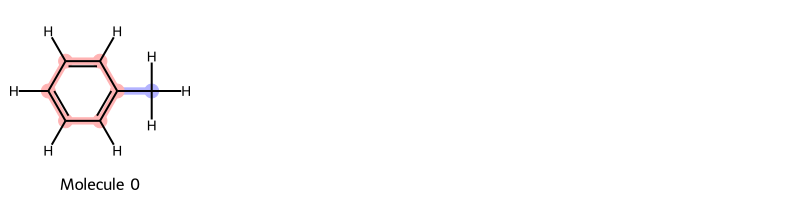

In [6]:
# Create a more complex molecule for better visualization
toluene_smiles = "Cc1ccccc1"  # Toluene
toluene_mol = Chem.MolFromSmiles(toluene_smiles)
toluene_mol = Chem.AddHs(toluene_mol)

# Select aromatic carbons and methyl carbon
aromatic_carbons = rdkit2ase.select_atoms_flat_unique(toluene_mol, "c")
methyl_carbon = rdkit2ase.select_atoms_flat_unique(toluene_mol, "[C;!c]")

print(f"Aromatic carbons: {aromatic_carbons}")
print(f"Methyl carbon: {methyl_carbon}")

# Visualize with different colors
img = rdkit2ase.visualize_selected_molecules(toluene_mol, aromatic_carbons, methyl_carbon)
img

## Advanced Example: Selecting Functional Groups

Let's demonstrate a more complex example with a molecule containing multiple functional groups.

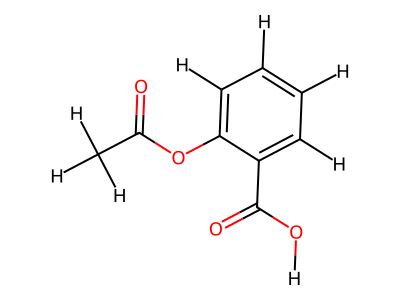

In [7]:
# Create a molecule with multiple functional groups (aspirin)
aspirin_smiles = "CC(=O)Oc1ccccc1C(=O)O"
aspirin_mol = Chem.MolFromSmiles(aspirin_smiles)
aspirin_mol = Chem.AddHs(aspirin_mol)

# Display the molecule
Draw.MolToImage(aspirin_mol, size=(400, 300))

Ester oxygen atoms: [3, 12]
Carbonyl carbon atoms: [1, 10]


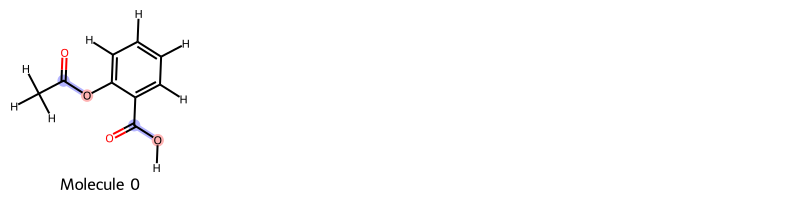

In [8]:
# Select different functional groups using mapped SMILES

# Select only the oxygen atoms in ester groups
ester_oxygens = rdkit2ase.select_atoms_flat_unique(aspirin_mol, "C(=O)[O:1]")
print(f"Ester oxygen atoms: {ester_oxygens}")

# Select only the carbonyl carbons
carbonyl_carbons = rdkit2ase.select_atoms_flat_unique(aspirin_mol, "[C:1](=O)")
print(f"Carbonyl carbon atoms: {carbonyl_carbons}")

# Visualize both selections
img = rdkit2ase.visualize_selected_molecules(aspirin_mol, ester_oxygens, carbonyl_carbons)
img

## Integration with ASE Atoms Objects

These selection functions work seamlessly with the rdkit2ase workflow for ASE Atoms objects.

In [9]:
# Convert SMILES to ASE Atoms object
ethanol_atoms = rdkit2ase.smiles2atoms("CCO")
print(f"ASE Atoms object: {ethanol_atoms}")
print(f"Chemical symbols: {ethanol_atoms.get_chemical_symbols()}")

# Convert back to RDKit for advanced selection
ethanol_rdkit = rdkit2ase.ase2rdkit(ethanol_atoms)

# Now use advanced selection
oh_group = rdkit2ase.select_atoms_flat_unique(ethanol_rdkit, "[O:1][H:2]", hydrogens="include")
print(f"OH group atoms: {oh_group}")

# Extract the selected atoms as a new ASE object
# First convert back to ASE with the same atom ordering
full_ethanol = rdkit2ase.rdkit2ase(ethanol_rdkit)
oh_fragment = full_ethanol[oh_group]
print(f"OH fragment: {oh_fragment}")
print(f"OH fragment symbols: {oh_fragment.get_chemical_symbols()}")

ASE Atoms object: Atoms(symbols='C2OH6', pbc=False)
Chemical symbols: ['C', 'C', 'O', 'H', 'H', 'H', 'H', 'H', 'H']
OH group atoms: [2, 8]
OH fragment: Atoms(symbols='OH', pbc=False)
OH fragment symbols: ['O', 'H']


## Summary

The advanced atom selection functions provide:

1. **`select_atoms_flat_unique`**: Advanced atom selection with:
   - Support for both SMARTS and mapped SMILES patterns
   - Sophisticated hydrogen handling (include, exclude, isolated)
   - Returns unique, flat lists of atom indices

2. **`visualize_selected_molecules`**: Molecule visualization with:
   - Highlighting of two different atom selections
   - Automatic deduplication of identical structures
   - Support for multi-fragment molecules

These functions complement the existing `match_substructure` and `get_substructures` functions by providing more fine-grained control over atom selection and better integration with complex molecular analysis workflows.